# Word Embeddings 

<img src="images/alexa.gif" alt="Drawing" style="width: 700px;"/>

# Outline

1. Machine Readable Representations : one Hot Encoding
2. Context in a text corpus 
3. Word Embeddings Introduction
4. Implementing a basic skip gram model 
5. Visualizing word embeddings

## How do computers understand words?

### I. One Hot Encoding

In [279]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

In [222]:

docs = "This talk is making me hungry".lower().split()
doc1 = set(docs)
doc1 = sorted(doc1)
print ("\nvalues: ", doc1)

integer_encoded = []
for i in docs:
    v = np.where( np.array(doc1) == i)[0][0]
    integer_encoded.append(v)
print ("\ninteger encoded: ",integer_encoded)

def get_vec(len_doc,word):
    empty_vector = [0] * len_doc
    vect = 0
    find = np.where( np.array(doc1) == word)[0][0]
    empty_vector[find] = 1
    return empty_vector

def get_matrix(doc1):
    mat = []
    len_doc = len(doc1)
    for i in docs:
        vec = get_vec(len_doc,i)
        mat.append(vec)
        
    return np.asarray(mat)

print ("\nMATRIX:")
print (get_matrix(doc1))


values:  ['hungry', 'is', 'making', 'me', 'talk', 'this']

integer encoded:  [5, 4, 1, 2, 3, 0]

MATRIX:
[[0 0 0 0 0 1]
 [0 0 0 0 1 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [1 0 0 0 0 0]]


 
### Checkpoint:
### Issues with this approach? 

1. Consider the following similar sentences: 
    - Jack is my friend 
    - Jack and I are buddies 

    
2. Explosive dimensions
3. "friend" and "buddies" are actually similar in meaning but different in representation! Our objective is to have words with similar context occupy close spatial positions. Mathematically, the cosine of the angle between such vectors should be close to 1, i.e. angle close to 0.




In [41]:
# vectors
a = np.array([0,0,0,1,0,0,0])
b = np.array([0,0,0,0,1,0,0])

# use library, operates on sets of vectors
aa = a.reshape(1,len(a))
ba = b.reshape(1,len(b))
cos_lib = cosine_similarity(aa, ba)
print(
    cos_lib[0][0]
)

0.0


In one hot encoding representations, all the words are independent of each other, how do we show dependence?
- Current situation : Similarity(Mango, Strawberry) == Similarity(Mango, City) == 0
- Ideal situation : Similarity(Mango, Strawberry) >> Similarity(Mango, City)


We should project these N dimensional one-hot encoded vectors into a space that provides context and dependence!
<img src="images/cosine.png" alt="Drawing" style="width: 500px;"/>



## Context : How do we learn it? 

- If we have a document filled with sentences, the context for a word $w$ at position $p$ is the word at position $p-1$ and $p+1$
- If we want greater context a window of $k$ words before and after $w$ could be considered ie. in positions $(p-1-k, p-1)$ and $(p+1, p+1+k)$
- If that case, $w$ could also be be used to predict different words in its search window


#### When window words predict $w$ 
In the Continuous Bag Of Words model, the distributed representations of context (or surrounding words) are combined to predict the word in the middle.
#### When $w$ predicts window words
In the Skip-gram model, the distributed representation of the input word is used to predict the context/window words.


<img src="images/skip_cbow.png" alt="Drawing" style="width: 700px;"/>

### Catch 22 !
If we dont have distributed representations of context window, how would be generate a distributed representation of a word in the middle? or vice versa?

### Neural Representations 

We’ll do so by creating a “fake” task for the neural network to train. We won’t be interested in the inputs and outputs of this network, rather the goal is actually just to learn the weights of the hidden layer that are actually the “vectors” that we’re trying to learn which will be our "word embeddings".

The training objective of the Skip-gram model is to find word representations that are useful for
predicting the surrounding words in a sentence or a document. More formally, given a sequence of
training words $w_1, w_2, w_3, . . . , w_T$ , the objective of the Skip-gram model is to maximize the average
log probability of predicting $w$ given its previous words.

<img src="images/skip.png" alt="Drawing" style="width: 700px;"/>
<img src="images/softmax.png" alt="Drawing" style="width: 700px;"/>

### Cost Function 

- Taken from the source paper of word embeddings published by Google.
- The cost function to minimize if the negative log probability of predicting window words conditioned on the center word. 
- Using this as our objective function and deriving on dependent variables we use stochastic gradient descent to learn the weights of the neurons 

<img src="images/costfunc.png" alt="Drawing" style="width: 700px;"/>


## III. Word Embeddings : Implementation from scratch!

### Data Preparation 

In [267]:
def tokenize(text):
    # obtains tokens with a least 1 alphabet
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

def mapping(tokens):
    # creates a mapping of word to index and index to word
    word_to_id = dict()
    id_to_word = dict()
    for i, token in enumerate(set(tokens)):
        word_to_id[token] = i
        id_to_word[i] = token
        
    return word_to_id, id_to_word

def generate_training_data(tokens, word_to_id, window_size):
    #every data point (X,Y) represents that Y is in the window specified for the input word X.
    N = len(tokens)
    X, Y = [], []
    
    for i in range(N):
        neighbour_indices = list(range(max(0, i - window_size), i)) + list(range(i + 1, min(N, i + window_size + 1)))
        #for every neighbouring index within window size, create a data point.
        for j in neighbour_indices:
            X.append(word_to_id[tokens[i]])
            Y.append(word_to_id[tokens[j]])
            
    X = np.array(X)
    X = np.expand_dims(X, axis=0)
    Y = np.array(Y)
    Y = np.expand_dims(Y, axis=0)
            
    return X, Y

### Forward Propogation, Backward Propogation, Cost Function

In [273]:
def initialize_wrd_emb(vocab_size, emb_size):
    """
    vocab_size: int. vocabulary size of your corpus or training data
    emb_size: int. word embedding size. How many dimensions to represent each vocabulary
    """
    WRD_EMB = np.random.randn(vocab_size, emb_size) * 0.01
    
    assert(WRD_EMB.shape == (vocab_size, emb_size))
    return WRD_EMB

def initialize_dense(input_size, output_size):
    """
    input_size: int. size of the input to the dense layer
    output_szie: int. size of the output out of the dense layer
    """
    W = np.random.randn(output_size, input_size) * 0.01
    
    assert(W.shape == (output_size, input_size))
    return W

def initialize_parameters(vocab_size, emb_size):
    WRD_EMB = initialize_wrd_emb(vocab_size, emb_size)
    W = initialize_dense(emb_size, vocab_size)
    
    parameters = {}
    parameters['WRD_EMB'] = WRD_EMB
    parameters['W'] = W
    
    return parameters

def ind_to_word_vecs(inds, parameters):
    """
    inds: numpy array. shape: (1, m)
    parameters: dict. weights to be trained
    """
    m = inds.shape[1]
    WRD_EMB = parameters['WRD_EMB']
    word_vec = WRD_EMB[inds.flatten(), :].T
    
    assert(word_vec.shape == (WRD_EMB.shape[1], m))
    
    return word_vec

def linear_dense(word_vec, parameters):
    """
    word_vec: numpy array. shape: (emb_size, m)
    parameters: dict. weights to be trained
    """
    m = word_vec.shape[1]
    W = parameters['W']
    Z = np.dot(W, word_vec)
    
    assert(Z.shape == (W.shape[0], m))
    
    return W, Z

def softmax(Z):
    """
    Z: output out of the dense layer. shape: (vocab_size, m)
    """
    softmax_out = np.divide(np.exp(Z), np.sum(np.exp(Z), axis=0, keepdims=True) + 0.001)
    
    assert(softmax_out.shape == Z.shape)

    return softmax_out

def forward_propagation(inds, parameters):
    word_vec = ind_to_word_vecs(inds, parameters)
    W, Z = linear_dense(word_vec, parameters)
    softmax_out = softmax(Z)
    
    caches = {}
    caches['inds'] = inds
    caches['word_vec'] = word_vec
    caches['W'] = W
    caches['Z'] = Z
    
    return softmax_out, caches

def cross_entropy(softmax_out, Y):
    """
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    m = softmax_out.shape[1]
    cost = -(1 / m) * np.sum(np.sum(Y * np.log(softmax_out + 0.001), axis=0, keepdims=True), axis=1)
    return cost

def softmax_backward(Y, softmax_out):
    """
    Y: labels of training data. shape: (vocab_size, m)
    softmax_out: output out of softmax. shape: (vocab_size, m)
    """
    dL_dZ = softmax_out - Y
    
    assert(dL_dZ.shape == softmax_out.shape)
    return dL_dZ

def dense_backward(dL_dZ, caches):
    """
    dL_dZ: shape: (vocab_size, m)
    caches: dict. results from each steps of forward propagation
    """
    W = caches['W']
    word_vec = caches['word_vec']
    m = word_vec.shape[1]
    
    dL_dW = (1 / m) * np.dot(dL_dZ, word_vec.T)
    dL_dword_vec = np.dot(W.T, dL_dZ)

    assert(W.shape == dL_dW.shape)
    assert(word_vec.shape == dL_dword_vec.shape)
    
    return dL_dW, dL_dword_vec

def backward_propagation(Y, softmax_out, caches):
    dL_dZ = softmax_backward(Y, softmax_out)
    dL_dW, dL_dword_vec = dense_backward(dL_dZ, caches)
    
    gradients = dict()
    gradients['dL_dZ'] = dL_dZ
    gradients['dL_dW'] = dL_dW
    gradients['dL_dword_vec'] = dL_dword_vec
    
    return gradients

def update_parameters(parameters, caches, gradients, learning_rate):
    vocab_size, emb_size = parameters['WRD_EMB'].shape
    inds = caches['inds']
    dL_dword_vec = gradients['dL_dword_vec']
    m = inds.shape[-1]
    
    parameters['WRD_EMB'][inds.flatten(), :] -= dL_dword_vec.T * learning_rate

    parameters['W'] -= learning_rate * gradients['dL_dW']

### Model Training

In [280]:
def skipgram_model_training(X, Y, vocab_size, emb_size, learning_rate, epochs, batch_size=256, parameters=None, print_cost=False, plot_cost=True):
    costs = []
    m = X.shape[1]
    
    if parameters is None:
        parameters = initialize_parameters(vocab_size, emb_size)
    
    begin_time = datetime.now()
    for epoch in range(epochs):
        epoch_cost = 0
        batch_inds = list(range(0, m, batch_size))
        np.random.shuffle(batch_inds)
        for i in batch_inds:
            X_batch = X[:, i:i+batch_size]
            Y_batch = Y[:, i:i+batch_size]

            softmax_out, caches = forward_propagation(X_batch, parameters)
            gradients = backward_propagation(Y_batch, softmax_out, caches)
            update_parameters(parameters, caches, gradients, learning_rate)
            cost = cross_entropy(softmax_out, Y_batch)
            epoch_cost += np.squeeze(cost)
            
        costs.append(epoch_cost)
        if print_cost and epoch % (epochs // 500) == 0:
            print("Cost after epoch {}: {}".format(epoch, epoch_cost))
        if epoch % (epochs // 100) == 0:
            learning_rate *= 0.98
    end_time = datetime.now()
    print('training time: {}'.format(end_time - begin_time))
            
    if plot_cost:
        plt.plot(np.arange(epochs), costs)
        plt.xlabel('# of epochs')
        plt.ylabel('cost')
    return parameters

In [337]:
doc = "This talk will be going on forever. " \
      "When will the talk stop."\
        "I have to feed my dog"
tokens = tokenize(doc)
word_to_id, id_to_word = mapping(tokens)
window_size=3
X, Y = generate_training_data(tokens, word_to_id, window_size)
vocab_size = len(id_to_word)
m = Y.shape[1]
# turn Y into one hot encoding
Y_one_hot = np.zeros((vocab_size, m))
Y_one_hot[Y.flatten(), np.arange(m)] = 1

In [338]:
word_to_id

{'on': 0,
 'going': 1,
 'feed': 2,
 'stop': 3,
 'my': 4,
 'will': 5,
 'the': 6,
 'be': 7,
 'talk': 8,
 'when': 9,
 'i': 10,
 'to': 11,
 'forever': 12,
 'have': 13,
 'dog': 14,
 'this': 15}

In [339]:
X  # notice the consecutive indices representing that each predictor word will be listed for every context word in Y

array([[15, 15, 15,  8,  8,  8,  8,  5,  5,  5,  5,  5,  7,  7,  7,  7,
         7,  7,  1,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0, 12, 12,
        12, 12, 12, 12,  9,  9,  9,  9,  9,  9,  5,  5,  5,  5,  5,  5,
         6,  6,  6,  6,  6,  6,  8,  8,  8,  8,  8,  8,  3,  3,  3,  3,
         3,  3, 10, 10, 10, 10, 10, 10, 13, 13, 13, 13, 13, 13, 11, 11,
        11, 11, 11, 11,  2,  2,  2,  2,  2,  4,  4,  4,  4, 14, 14, 14]])

In [332]:
Y

array([[ 8,  5,  7,  1,  0, 15,  5,  7,  1,  0, 12, 15,  8,  7,  1,  0,
        12,  9, 15,  8,  5,  1,  0, 12,  9,  5, 15,  8,  5,  7,  0, 12,
         9,  5,  6, 15,  8,  5,  7,  1, 12,  9,  5,  6,  8,  8,  5,  7,
         1,  0,  9,  5,  6,  8,  3,  5,  7,  1,  0, 12,  5,  6,  8,  3,
        10,  7,  1,  0, 12,  9,  6,  8,  3, 10, 13,  1,  0, 12,  9,  5,
         8,  3, 10, 13, 11,  0, 12,  9,  5,  6,  3, 10, 13, 11,  2, 12,
         9,  5,  6,  8, 10, 13, 11,  2,  4,  9,  5,  6,  8,  3, 13, 11,
         2,  4, 14,  5,  6,  8,  3, 10, 11,  2,  4, 14,  6,  8,  3, 10,
        13,  2,  4, 14,  8,  3, 10, 13, 11,  4, 14,  3, 10, 13, 11,  2,
        14, 10, 13, 11,  2,  4]])

Cost after epoch 0: 5.5135205132375305
Cost after epoch 10: 5.513033802217092
Cost after epoch 20: 5.512401467263429
Cost after epoch 30: 5.511456134681019
Cost after epoch 40: 5.510033086108528
Cost after epoch 50: 5.5078967364186875
Cost after epoch 60: 5.504816303842252
Cost after epoch 70: 5.5004091838521845
Cost after epoch 80: 5.494197789442847
Cost after epoch 90: 5.485584001616172
Cost after epoch 100: 5.473883846408286
Cost after epoch 110: 5.4584144522720335
Cost after epoch 120: 5.438417891164461
Cost after epoch 130: 5.412865226989614
Cost after epoch 140: 5.381321964359076
Cost after epoch 150: 5.343681873457037
Cost after epoch 160: 5.302300499839579
Cost after epoch 170: 5.257781736894513
Cost after epoch 180: 5.213430234087434
Cost after epoch 190: 5.17220321768145
Cost after epoch 200: 5.13593606568312
Cost after epoch 210: 5.107101276825694
Cost after epoch 220: 5.085147005108994
Cost after epoch 230: 5.068940147503739
Cost after epoch 240: 5.057822052072057
Cost afte

Cost after epoch 2120: 4.7236745266888915
Cost after epoch 2130: 4.723981145390549
Cost after epoch 2140: 4.724167362356811
Cost after epoch 2150: 4.724710052507081
Cost after epoch 2160: 4.72444721110001
Cost after epoch 2170: 4.725030031948108
Cost after epoch 2180: 4.7253475337187645
Cost after epoch 2190: 4.725368786125575
Cost after epoch 2200: 4.7253434751513534
Cost after epoch 2210: 4.725275981149071
Cost after epoch 2220: 4.725615428643537
Cost after epoch 2230: 4.72587641556712
Cost after epoch 2240: 4.726262617844657
Cost after epoch 2250: 4.72651381725033
Cost after epoch 2260: 4.7263346273033235
Cost after epoch 2270: 4.7268201243913595
Cost after epoch 2280: 4.727071906232494
Cost after epoch 2290: 4.726948997373691
Cost after epoch 2300: 4.727165115974903
Cost after epoch 2310: 4.727387993692615
Cost after epoch 2320: 4.727454458051203
Cost after epoch 2330: 4.727808639334139
Cost after epoch 2340: 4.727977459260076
Cost after epoch 2350: 4.728049381061105
Cost after epo

Cost after epoch 4230: 4.720684862692145
Cost after epoch 4240: 4.720745278347543
Cost after epoch 4250: 4.720627494780386
Cost after epoch 4260: 4.720381083104422
Cost after epoch 4270: 4.720495798244836
Cost after epoch 4280: 4.720678656772902
Cost after epoch 4290: 4.720748773155987
Cost after epoch 4300: 4.720855401417374
Cost after epoch 4310: 4.720680784913684
Cost after epoch 4320: 4.720645597523437
Cost after epoch 4330: 4.720621949260233
Cost after epoch 4340: 4.720514553683882
Cost after epoch 4350: 4.720556159511495
Cost after epoch 4360: 4.720665544957452
Cost after epoch 4370: 4.720637446994559
Cost after epoch 4380: 4.720716577799114
Cost after epoch 4390: 4.720671691447632
Cost after epoch 4400: 4.720575074043069
Cost after epoch 4410: 4.720536769456954
Cost after epoch 4420: 4.720616724605739
Cost after epoch 4430: 4.720737166894127
Cost after epoch 4440: 4.720742875479276
Cost after epoch 4450: 4.720669794086369
Cost after epoch 4460: 4.720801604970665
Cost after epoch

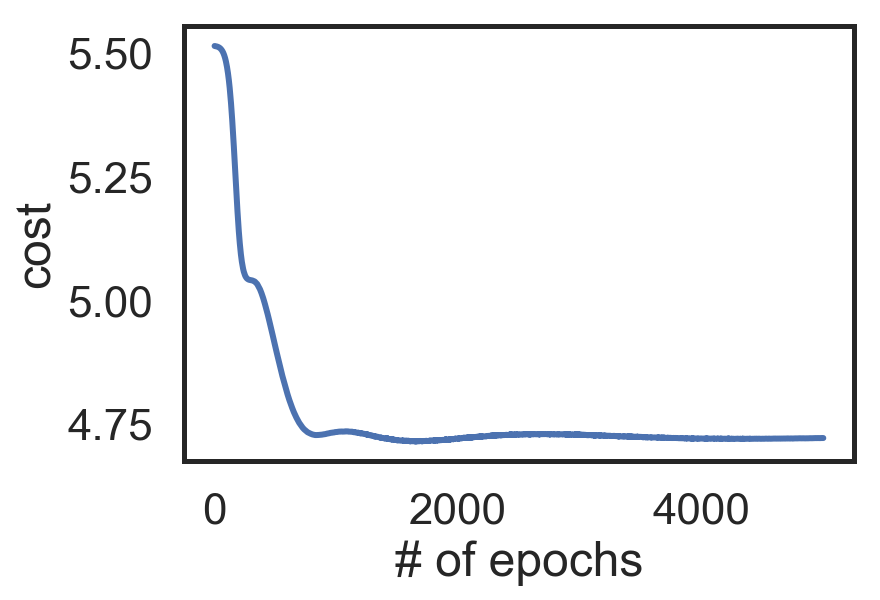

In [303]:
paras = skipgram_model_training(X, Y_one_hot, vocab_size, 50, 0.05, 5000, batch_size=128, parameters=None, print_cost=True)

## Evaluation

In [304]:
X_test = np.arange(vocab_size)
X_test = np.expand_dims(X_test, axis=0)
softmax_test, _ = forward_propagation(X_test, paras)

on's neighbor words: ['talk', 'will', 'when', 'be']
going's neighbor words: ['will', 'the', 'when', 'this']
feed's neighbor words: ['dog', 'have', 'stop', 'to']
stop's neighbor words: ['my', 'have', 'feed', 'i']
my's neighbor words: ['dog', 'have', 'stop', 'to']
will's neighbor words: ['have', 'i', 'feed', 'my']
the's neighbor words: ['to', 'have', 'i', 'my']
be's neighbor words: ['will', 'talk', 'on', 'going']
talk's neighbor words: ['feed', 'have', 'i', 'to']
when's neighbor words: ['have', 'i', 'feed', 'to']
i's neighbor words: ['dog', 'have', 'stop', 'to']
to's neighbor words: ['have', 'i', 'dog', 'feed']
forever's neighbor words: ['talk', 'will', 'stop', 'going']
have's neighbor words: ['dog', 'have', 'stop', 'to']
dog's neighbor words: ['my', 'feed', 'have', 'i']
this's neighbor words: ['on', 'talk', 'be', 'will']


In [313]:
#sort and get the words with high probability of being neighbourhood words
top_sorted_inds = np.argsort(softmax_test, axis=0)[-4:,:]

for input_ind in range(vocab_size):
    input_word = id_to_word[input_ind]
    output_words = [id_to_word[output_ind] for output_ind in top_sorted_inds[::-1, input_ind]]
    print("{}'s neighbor words: {}".format(input_word, output_words))

on's neighbor words: ['talk', 'will', 'when', 'be']
going's neighbor words: ['will', 'the', 'when', 'this']
feed's neighbor words: ['dog', 'have', 'stop', 'to']
stop's neighbor words: ['my', 'have', 'feed', 'i']
my's neighbor words: ['dog', 'have', 'stop', 'to']
will's neighbor words: ['have', 'i', 'feed', 'my']
the's neighbor words: ['to', 'have', 'i', 'my']
be's neighbor words: ['will', 'talk', 'on', 'going']
talk's neighbor words: ['feed', 'have', 'i', 'to']
when's neighbor words: ['have', 'i', 'feed', 'to']
i's neighbor words: ['dog', 'have', 'stop', 'to']
to's neighbor words: ['have', 'i', 'dog', 'feed']
forever's neighbor words: ['talk', 'will', 'stop', 'going']
have's neighbor words: ['dog', 'have', 'stop', 'to']
dog's neighbor words: ['my', 'feed', 'have', 'i']
this's neighbor words: ['on', 'talk', 'be', 'will']


### Issues?
- Small corpus
- Hyper parameter tuning ie. window size, SGD parameters 

## Word2Vec

- [Paper](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and patent by Google in 2013. 

- A library called word2vec which implements a fast, efficient neural network architecture that can create word embeddings out of any english corpus. A huge improvement to basic model we tried above. 

## Fun With Word Embeddings : Using word2vec

I extracted a few years of song lyrics from the spotify and billboard APIs. Let's see how word embeddings made out song lyrics look like!

### Import Libraries

In [72]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gensim.models import Word2Vec
from matplotlib import rcParams
from matplotlib.patches import Rectangle
from scipy.stats import relfreq
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, ENGLISH_STOP_WORDS

warnings.filterwarnings('ignore')

sns.set(context='poster', style='white')
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'arial'

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Dataset cleaning

In [342]:
df = pd.read_csv('music_lyrics.csv')
# drop words that dont appear more than once
min_count = 2
lyrics = df['lyrics'].dropna().values.tolist()
lyrics_tokenized = [lyric.split() for lyric in lyrics]
df.head()

,artist_all,artist_base,rank,song,year,artist_featured,song_clean,artist_clean,lyrics,acousticness,...,speechiness,tempo,time_signature,valence,duration_min,num_words,words_per_sec,num_uniq_words,decade,uniq_ratio
0,percy faith,percy faith,1,theme from a summer place,1960,NaN,theme from a summer place,percy faith,theres a summer place where it may rain or sto...,0.631,...,0.0253,92.631,4.0,0.749,2.414883,104.0,0.717771,58.0,1960,1.793103
1,jim reeves,jim reeves,2,he'll have to go,1960,NaN,hell have to go,jim reeves,put your sweet lips a little closer to the pho...,0.909,...,0.0379,81.181,3.0,0.200,2.310667,152.0,1.096365,69.0,1960,2.202899
2,the everly brothers,the everly brothers,3,cathy's clown,1960,NaN,cathys clown,the everly brothers,dont want your love any more dont want your k...,0.412,...,0.0339,119.809,4.0,0.866,2.400217,121.0,0.840202,64.0,1960,1.890625
3,johnny preston,johnny preston,4,running bear,1960,NaN,running bear,johnny preston,on the bank of the river stood running bear yo...,0.854,...,0.0530,119.987,4.0,0.822,2.636667,220.0,1.390645,89.0,1960,2.471910
4,mark dinning,mark dinning,5,teen angel,1960,NaN,teen angel,mark dinning,teen angel teen angel teen angel that fateful ...,0.936,...,0.0459,101.517,4.0,0.282,2.664883,109.0,0.681706,73.0,1960,1.493151


### Using Word2Vec

In [195]:
model = Word2Vec(lyrics_tokenized, size=50, min_count=min_count, window=5)

In [197]:
model["dance"]

array([-2.7915583 , -2.2957737 , -2.7612116 , -0.2726606 ,  2.9264293 ,
       -1.3082798 , -0.48182893,  0.8482519 , -0.02347481, -0.4241228 ,
       -0.3848431 ,  1.799516  ,  0.12198358,  1.4291245 , -1.6477093 ,
       -0.5820222 , -1.1053712 , -2.2327864 ,  0.47702506, -1.4638318 ,
       -1.4677914 , -0.5526057 ,  0.66744494,  0.9795402 ,  0.28003925,
       -2.749015  , -2.2026186 ,  3.4429257 , -0.25190645, -1.8363992 ,
       -2.9413435 ,  0.10911398,  0.73287916,  1.4028658 ,  1.9717115 ,
        0.9073041 , -1.2355869 ,  1.8760006 , -0.3308914 , -0.81034184,
        0.4757298 ,  0.35543364,  1.4739541 , -1.9770912 , -2.62065   ,
        3.2901785 ,  2.018754  , -0.73246765,  0.8117282 ,  0.8153262 ],
      dtype=float32)

### TSNE : Visualizing Word Embeddings

- t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. 
- The algorithms works by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

In [198]:
"""
Lets perform our visualization on words that are popular, for manual verficitaion
Step 1 : Find the count of each word in the lyrics corpus
Step 2 : Sort in descending order
Step 3 : Pick the top N words and store that in words_sorted
"""
n_words_display = 500
count = CountVectorizer(stop_words='english')
count.fit(np.array(lyrics))
freqs = np.array(count.transform(np.array(lyrics)).todense()).sum(axis=0)
mask = freqs >= min_count
indices = np.argsort(-freqs).squeeze().tolist()
freqs_filtered = freqs[indices]
words_sorted = np.array(count.get_feature_names())[indices]

In [199]:
words_sorted

array(['love', 'im', 'dont', ..., 'revolver', 'curbn', 'grilled'],
      dtype='<U34')

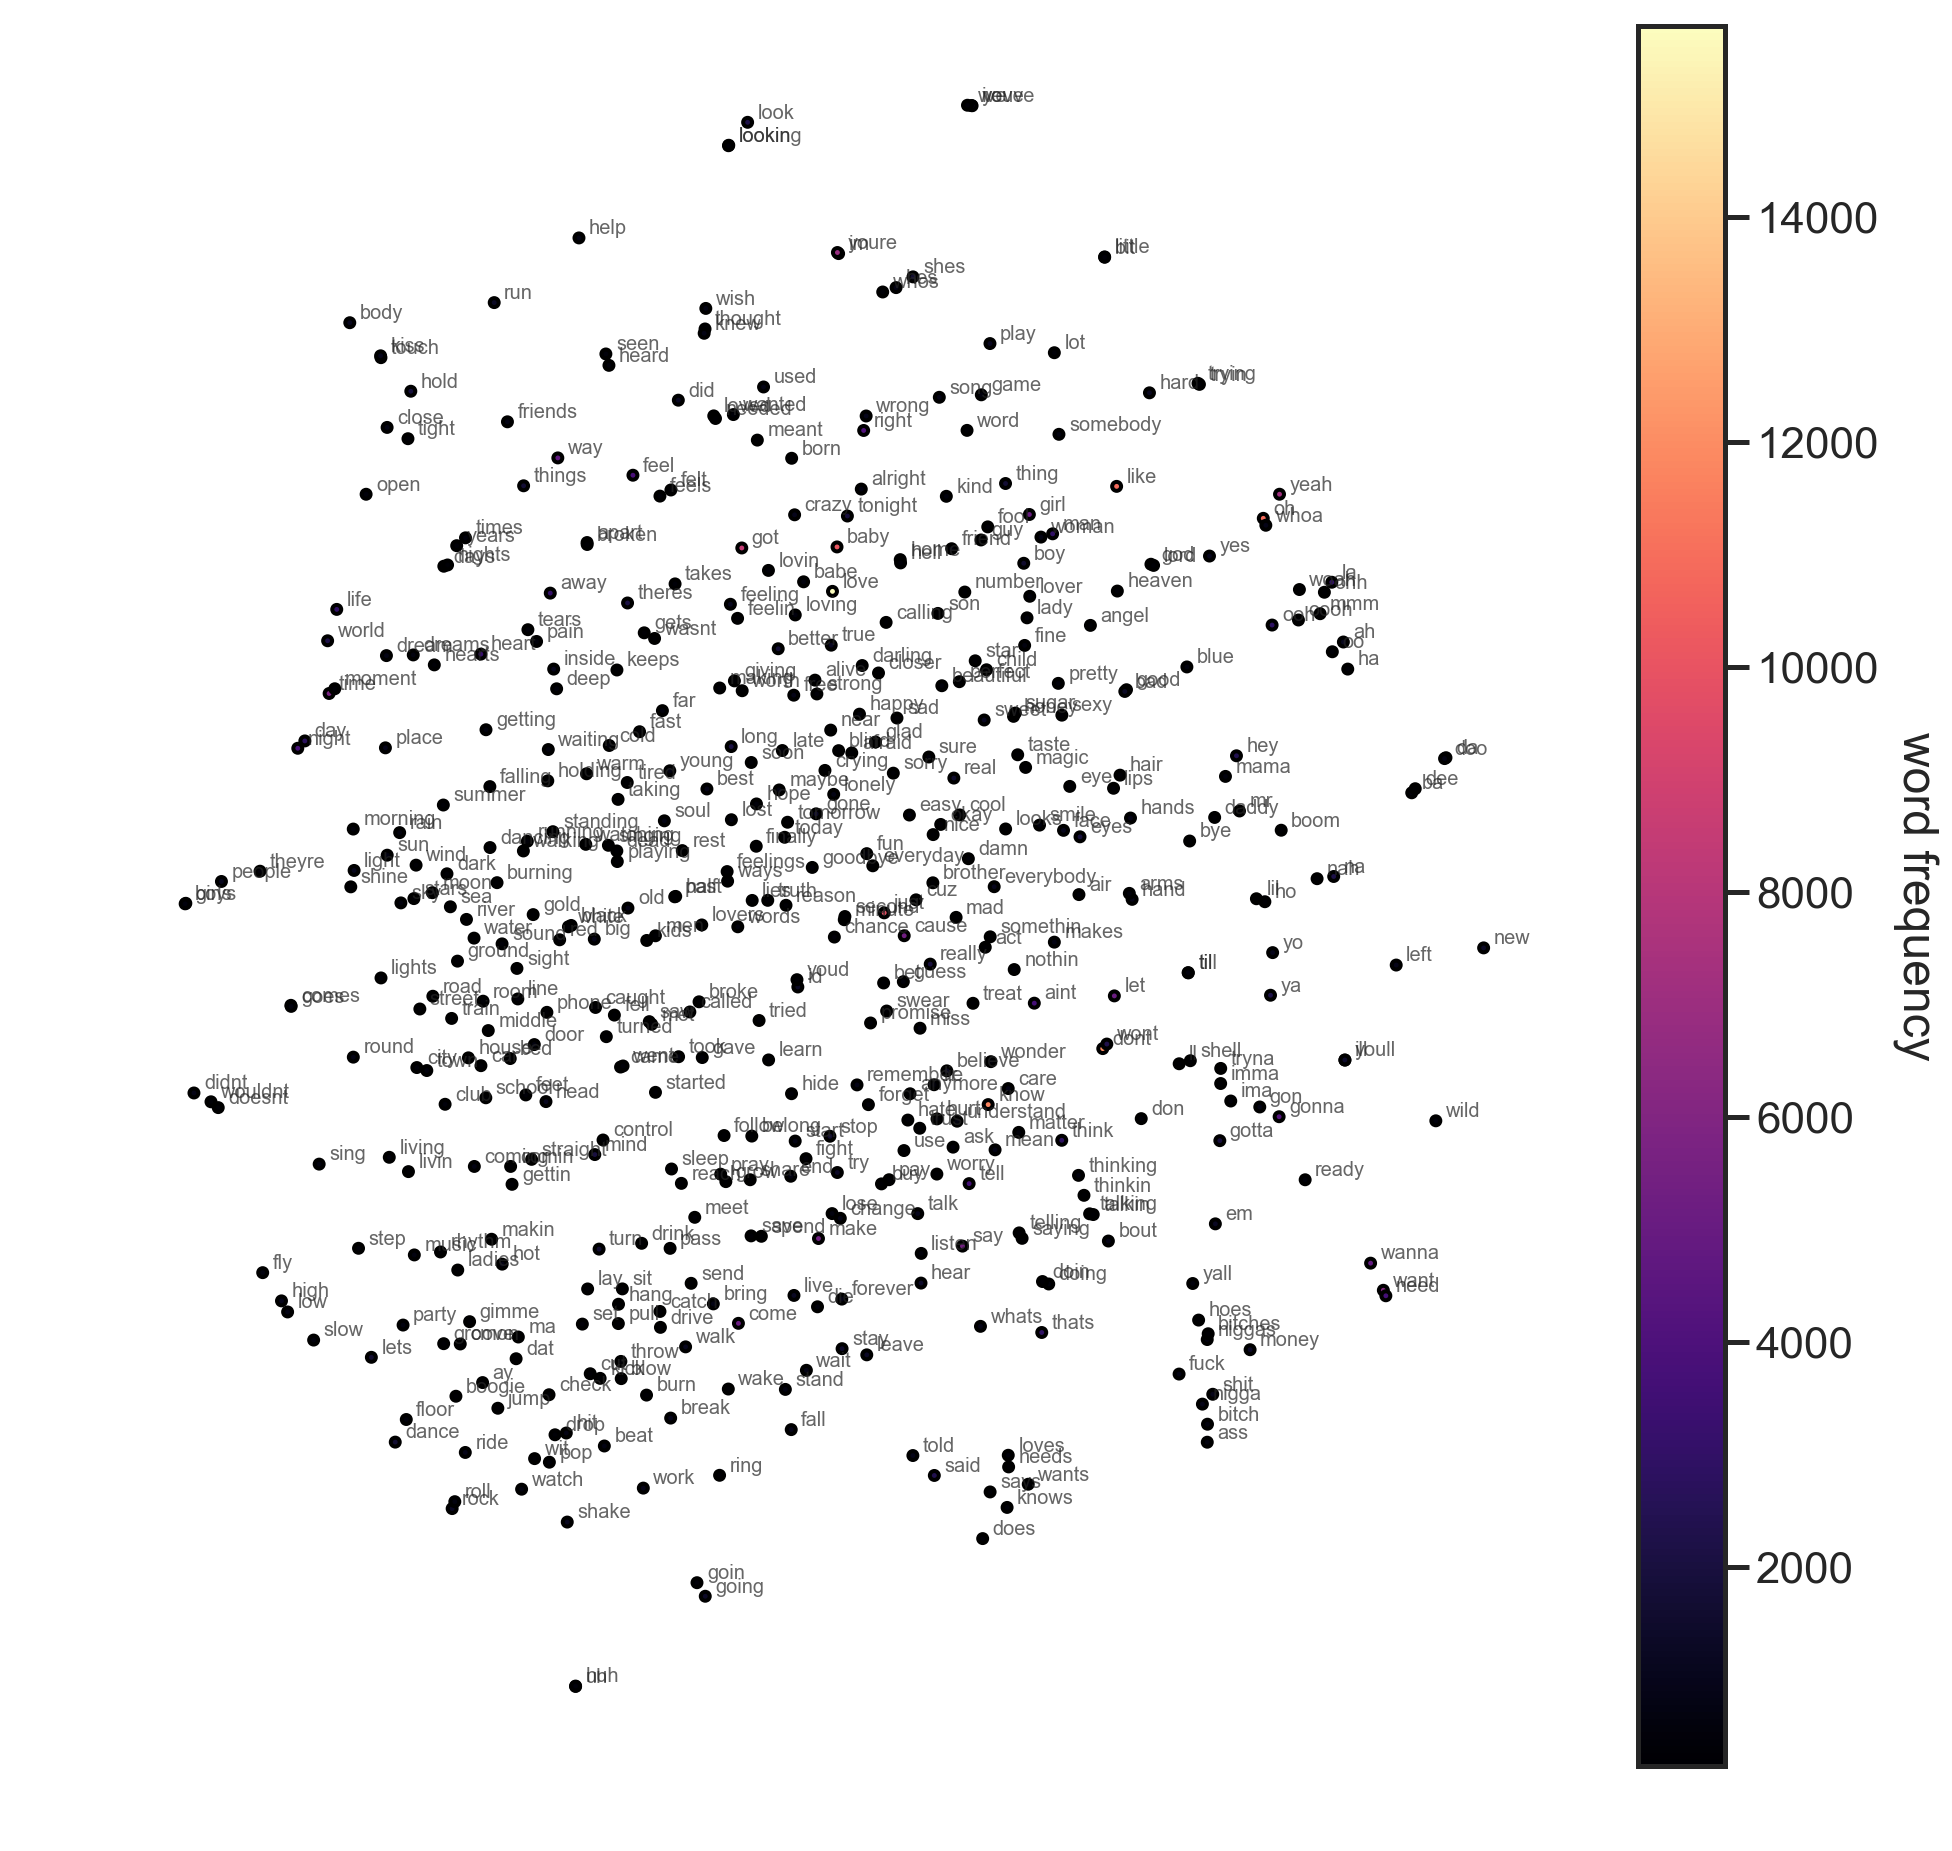

In [200]:
#In our word2vec model, pick the first N elements corresponding to first N words
X = model[words_sorted[:n_words_display]]

#call tsne and reduce dimensions to 2 for sake of visualization
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
# plot 2D projections of top n_words_display words
plt.figure(figsize=(16,16))
ax = plt.gca()
cb = ax.scatter(X_tsne[:,0], X_tsne[:,1], s=20, c=freqs_filtered[:n_words_display],
                cmap='magma', edgecolor='black')
cb = plt.colorbar(cb)
cb.set_label('word frequency', rotation=270, labelpad=30)
ax.axis('off')

# annotate each point
for index, word in enumerate(words_sorted[:n_words_display]):
    xy = X_tsne[index]
    ax.annotate(word, xy=xy, xytext=(5,2), textcoords='offset points',
                 alpha=0.7)

In [219]:
# print most similar words to query_words
query_words = ['girl', 'snoop', 'love', 'yeah', 'oh']
similar_words = [[res[0] for res in model.wv.most_similar(qw)] \
                         for qw in query_words]
for word in query_words:
    print('|{:^15}|'.format(word), end='')
print()
print('=' * 85)
for i in range(10):
    for j in range(5):
        print('|{:^15}|'.format(similar_words[j][i]), end='')
    print()

|     girl      ||     snoop     ||     love      ||     yeah      ||      oh       |
|     woman     ||    snoopy     ||    loving     ||      oh       ||     whoa      |
|     baby      ||     doggy     ||     baby      ||      goh      ||     lord      |
|     lady      ||     dogg      ||     true      ||    heeeeey    ||     yeah      |
|      boy      ||    ayyayai    ||     life      ||     whoa      ||      yes      |
|      you      ||      tak      ||    believe    ||      ah       ||     ohhh      |
|     fine      ||      sam      ||    because    ||    splurge    ||     woah      |
|     just      ||     aaaah     ||     lovin     ||     ohhh      ||     baby      |
|     that      ||      tik      ||     kiss      ||   nightlife   ||  billionaire  |
|     mine      ||     donne     ||     know      ||      woo      ||    darling    |
|      me       ||     louis     ||    promise    ||      uh       ||    darlin     |


### Bias in Datasets: How to avoid? 

- Use large open datasets by Google, Facebook etc.
- Use pre-trained embeddings
    - [GloVe](https://nlp.stanford.edu/projects/glove/)
    - [fastText](https://fasttext.cc/)
    
### GloVe : Try it for yourself !

- Download Glove [embeddings](http://nlp.stanford.edu/data/glove.6B.zip)
- Each line of the text file contains a word, followed by N numbers. The N numbers describe the vector of the word’s position. N may vary depending on which vectors you downloaded, for me, N is 50, since I am using glove.6B.50d.
- To load the pre-trained vectors, we must first create a dictionary that will hold the mappings between words, and the embedding vectors of those words.


In [223]:
embeddings_dict = {}
with open("glove.6B.50d.txt", 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        token = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[token] = vector

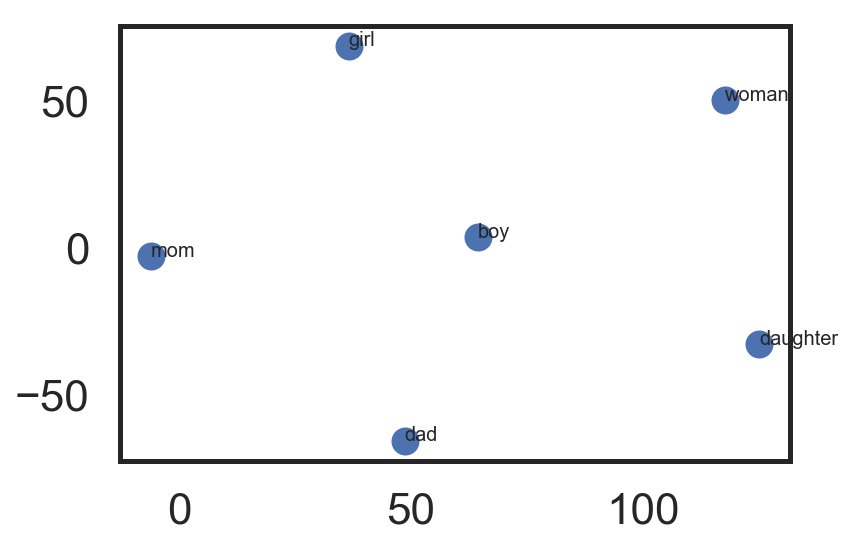

In [250]:
tsne = TSNE(n_components=2, random_state=0)

tokens = # fill in your tokens and check! 
vectors = [embeddings_dict[token] for token in tokens]

Y = tsne.fit_transform(vectors[:1000])

plt.scatter(Y[:, 0], Y[:, 1])
for label, x, y in zip(tokens, Y[:, 0], Y[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.show()

### Where to go from here?

- Create your own word2vec architecture : try CBOW!
- Create your own word embeddings and check for biases in a dataset
- Doc2Vec

# References

- http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
- https://towardsdatascience.com/nlp-101-word2vec-skip-gram-and-cbow-93512ee24314
- https://web.stanford.edu/class/cs224n/slides/cs224n-2020-lecture02-wordvecs2.pdf